**Цели и задачи проекта**: провести разведывательный анализ данных для определения параметров будущей модели, которая будет  
предсказывать результаты госэкзамена по математике для каждого ученика школы.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

data = pd.read_csv('stud_math.csv')

display(data.head(10))
data.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## **Предобработка данных**


Рассмотрим столбцы с пропусками:

In [55]:
null_data = data.isnull().sum().sort_values()
null_data[null_data>0]

Medu                    3
score                   6
studytime, granular     7
studytime               7
goout                   8
schoolsup               9
freetime               11
absences               12
activities             14
health                 15
nursery                16
address                17
reason                 17
Mjob                   19
higher                 20
failures               22
Fedu                   24
famrel                 27
famsize                27
traveltime             28
guardian               31
romantic               31
internet               34
Fjob                   36
famsup                 39
paid                   40
Pstatus                45
dtype: int64

Так как предсказываемая величина в нашем случае — переменная score, удалим строки с пропусками, их всего 6.

In [56]:
data.dropna(subset=['score'], inplace = True)

Так как все остальные переменные имеют категориальный признак, заменим пропуски на моду, напишем для этого функцию:

In [57]:
def replacement_nan(data, column):
    """Заменяем пропуски в столбцах с категориальными признаками на моду"""
    data[column] = data[column].fillna(data[column].mode()[0])
    return data


In [58]:
for col in data.columns:        #применяем функцию ко всем столбцам с пропусками
    replacement_nan(data, col)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              389 non-null    object 
 4   famsize              389 non-null    object 
 5   Pstatus              389 non-null    object 
 6   Medu                 389 non-null    float64
 7   Fedu                 389 non-null    float64
 8   Mjob                 389 non-null    object 
 9   Fjob                 389 non-null    object 
 10  reason               389 non-null    object 
 11  guardian             389 non-null    object 
 12  traveltime           389 non-null    float64
 13  studytime            389 non-null    float64
 14  failures             389 non-null    float64
 15  schoolsup            389 non-null    obj

Сделаем предварительный анализ на предположительное наличие выбросов, сравнивая статистические показатели:

In [59]:
data.describe() 

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,16.673522,2.776350,2.588689,1.403599,2.035990,0.308483,-6.107969,3.935733,3.218509,3.092545,3.586118,7.113111,52.262211
std,1.265662,1.095377,2.176604,0.676625,0.839575,0.712521,2.518726,0.898730,0.982353,1.106062,1.403572,23.310047,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,4.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


**Вывод:** аномальные данные есть в Fedu (данные не могут быть больше 4.0), famrel (данные не могут быть отрицательными),   
absences рассмотрим подробнее

<AxesSubplot:xlabel='absences'>

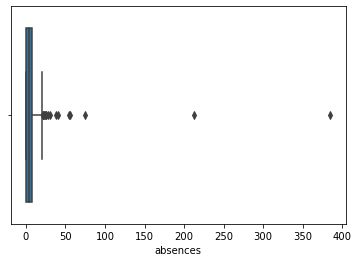

In [60]:
sns.boxplot(data=data, x='absences')

видим два аномальных выброса, посмотрим кто это:

In [61]:
data[data['absences'] > 200]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,mother,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


**Вывод:** учитывая, что у ученика с итоговой оценкой 85 не может быть 385 пропусков, то это скорее всего ошибка, насчет 212 пропусков,  
может и вероятно, удалять не будем

In [62]:
data_fin = data[(data['absences'] < 213) & (data['Fedu'] <= 4) & (data['famrel'] > 0)] 
#формируем финальный датафрейм, удаляя выбросы
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               386 non-null    object 
 1   sex                  386 non-null    object 
 2   age                  386 non-null    int64  
 3   address              386 non-null    object 
 4   famsize              386 non-null    object 
 5   Pstatus              386 non-null    object 
 6   Medu                 386 non-null    float64
 7   Fedu                 386 non-null    float64
 8   Mjob                 386 non-null    object 
 9   Fjob                 386 non-null    object 
 10  reason               386 non-null    object 
 11  guardian             386 non-null    object 
 12  traveltime           386 non-null    float64
 13  studytime            386 non-null    float64
 14  failures             386 non-null    float64
 15  schoolsup            386 non-null    obj

## **Корреляционный анализ численных/оценочных переменных**

In [63]:
data_fin.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.150896,-0.139851,0.083361,-0.015966,0.209748,0.015966,0.054773,0.007772,0.114849,-0.060204,0.208340,-0.154280
Medu,-0.150896,1.000000,0.588930,-0.155509,0.076227,-0.237833,-0.076227,-0.011392,0.035983,0.063774,-0.069041,0.031517,0.204199
Fedu,-0.139851,0.588930,1.000000,-0.117202,0.006140,-0.258665,-0.006140,-0.021769,-0.019477,0.051703,-0.015211,-0.001776,0.121963
traveltime,0.083361,-0.155509,-0.117202,1.000000,-0.108446,0.041373,0.108446,-0.046545,-0.011521,0.048744,-0.036586,-0.019574,-0.057875
studytime,-0.015966,0.076227,0.006140,-0.108446,1.000000,-0.162471,-1.000000,0.024087,-0.123310,-0.054576,-0.061920,-0.037057,0.112520
failures,0.209748,-0.237833,-0.258665,0.041373,-0.162471,1.000000,0.162471,-0.009338,0.094661,0.105480,0.073412,0.129356,-0.335618
"studytime, granular",0.015966,-0.076227,-0.006140,0.108446,-1.000000,0.162471,1.000000,-0.024087,0.123310,0.054576,0.061920,0.037057,-0.112520
famrel,0.054773,-0.011392,-0.021769,-0.046545,0.024087,-0.009338,-0.024087,1.000000,0.160965,0.054776,0.101193,0.031577,0.056902
freetime,0.007772,0.035983,-0.019477,-0.011521,-0.123310,0.094661,0.123310,0.160965,1.000000,0.290241,0.071979,0.031173,0.017820
goout,0.114849,0.063774,0.051703,0.048744,-0.054576,0.105480,0.054576,0.054776,0.290241,1.000000,-0.013929,0.052109,-0.122514


**Вывод:**  'studytime' и 'studytime, granular' коррелируются   полностью, столбец 'studytime, granular' можно не брать в рассмотрение.  

Коэффициент корреляции >0.1 в столбцах 'Medu', 'Fedu', 'studytime', 'failures', 'goout'. Берем эти столбцы для построения модели. 


## **Анализ номинативных переменных**

In [64]:
nominate = data.select_dtypes(include = ['object']).columns #выделяем номинативные переменные
nominate

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [65]:
def get_boxplot(column):
    """Функция построения boxplot графиков"""
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data_fin, ax=ax)
    plt.xticks(rotation=50)
    ax.set_title('Boxplot for ' + column)
    plt.show()

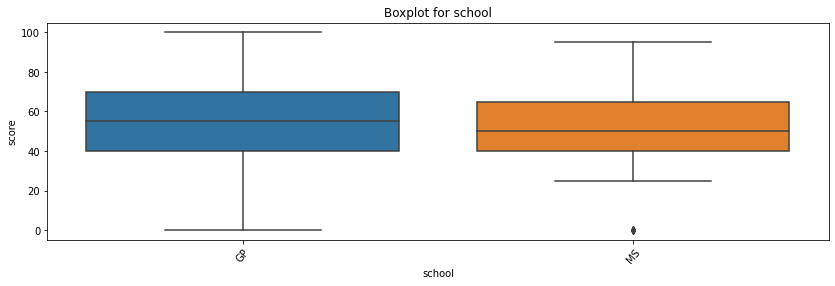

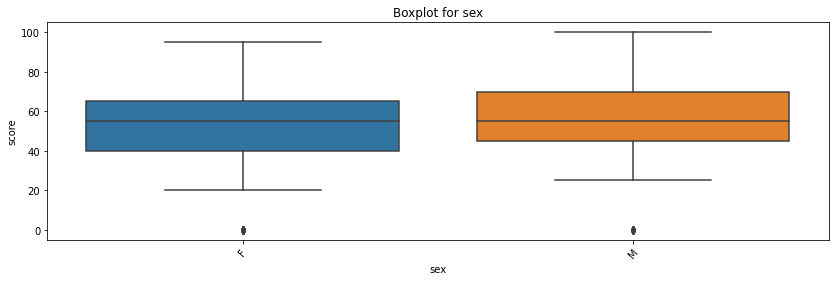

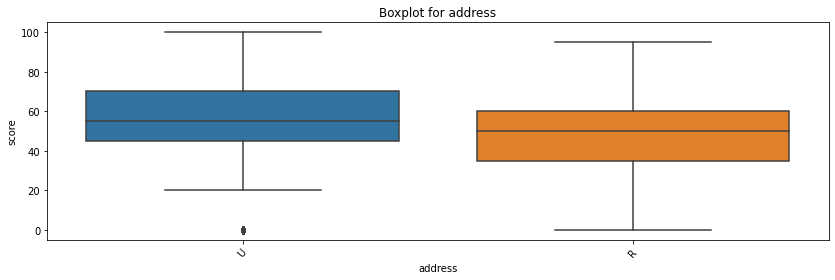

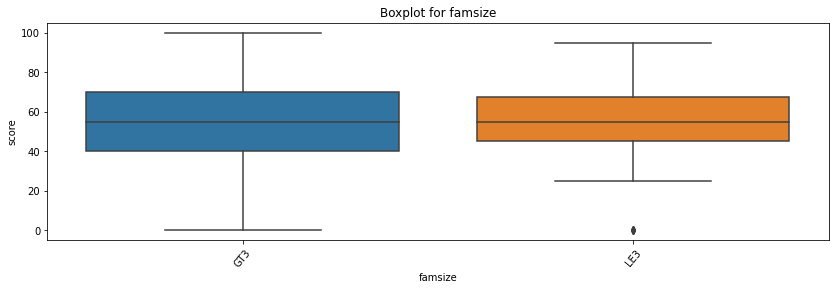

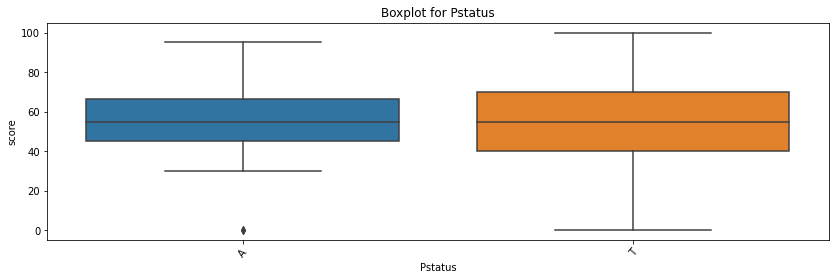

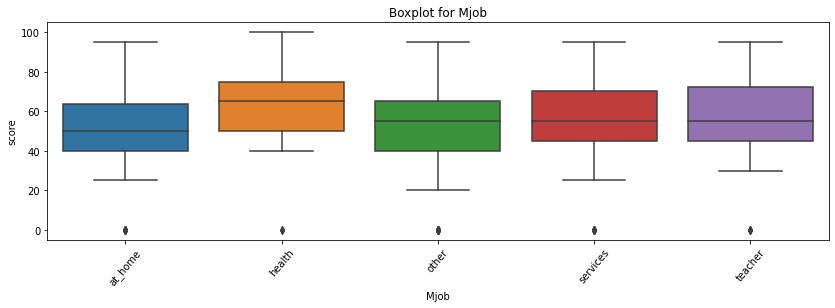

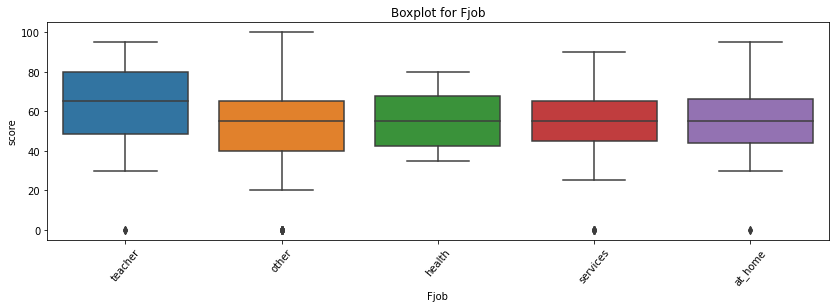

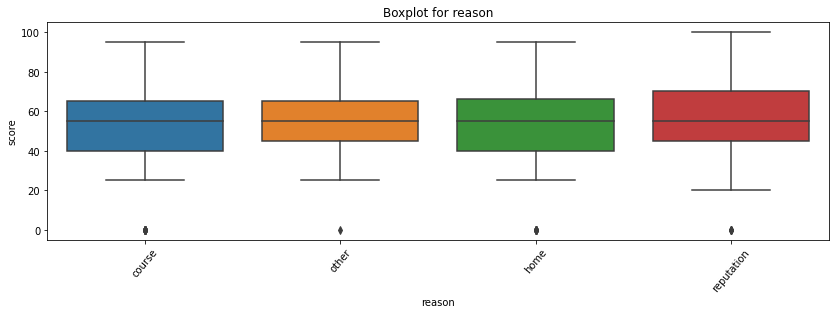

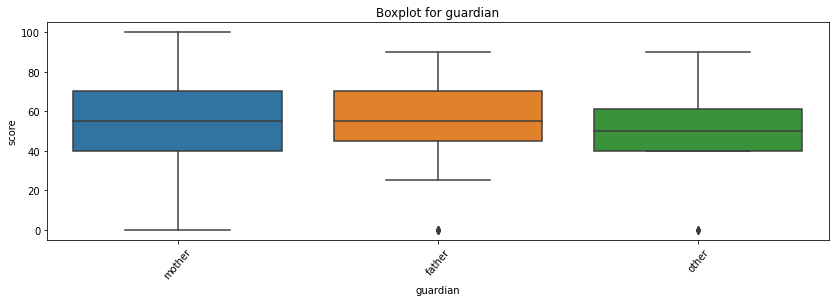

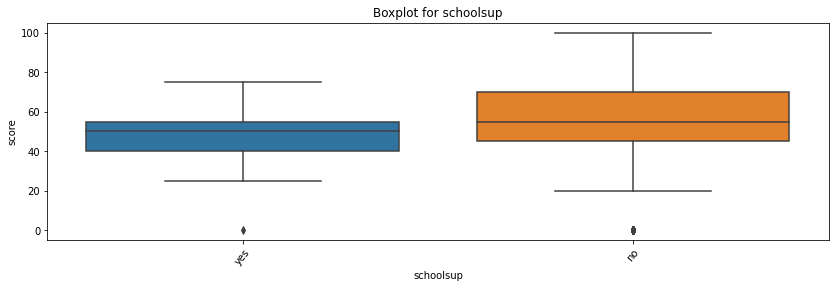

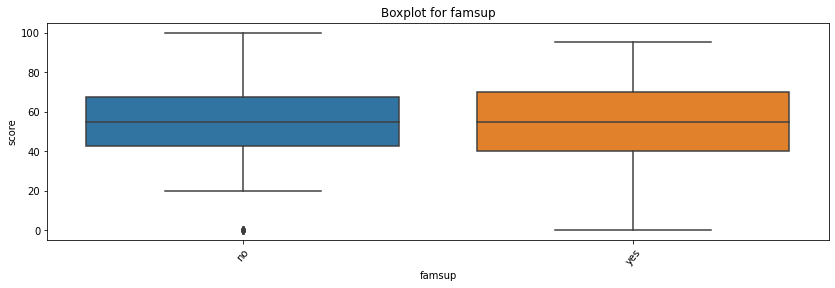

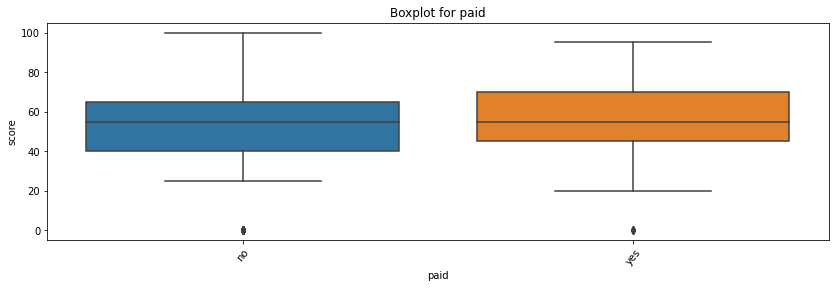

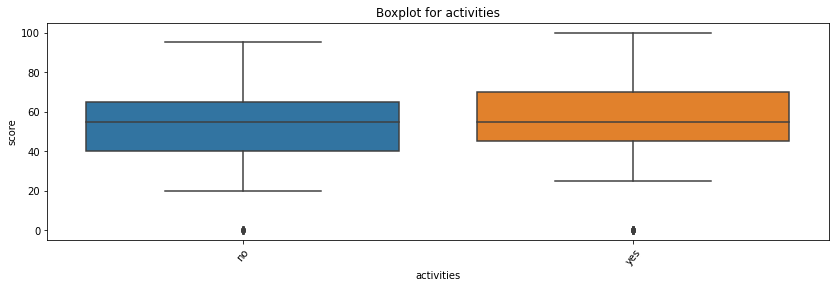

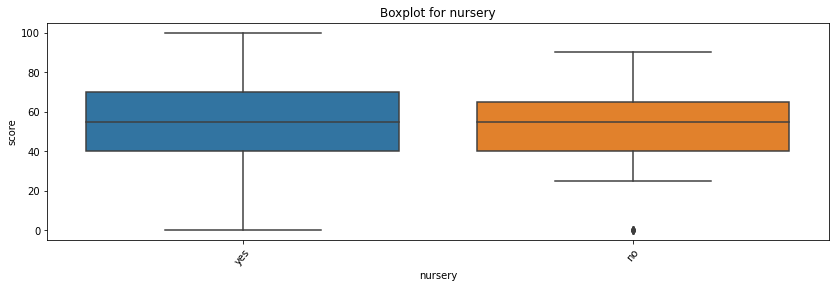

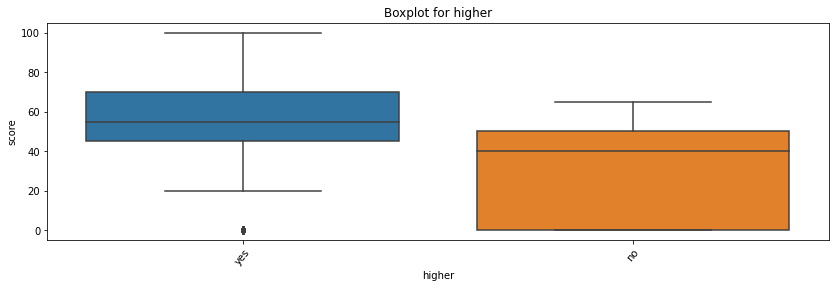

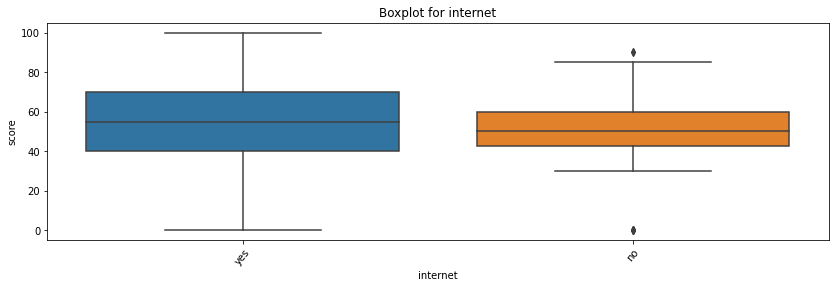

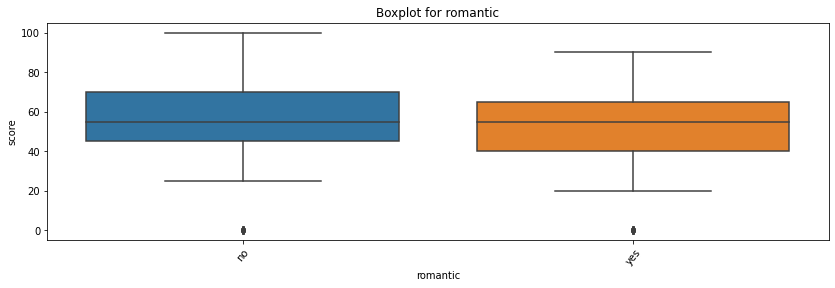

In [66]:
for col in nominate:
    get_boxplot(col)

Проведем для этих показателей тест Стьюдента на наличие статистически значимых различий:

In [67]:
def get_stat_dif(column):
    cols = data_fin.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data_fin.loc[data_fin.loc[:, column] == comb[0], 'score'], 
                        data_fin.loc[data_fin.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    
for col in nominate:
    
    get_stat_dif(col)      

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


## **ВЫВОД**  
Для построения модели можно использовать следующие параметры:  
'Medu', 'Fedu', 'studytime', 'failures', 'goout', 'sex', 'address', 'Mjob', 'paid', 'higher', 'romantic'  